In [1]:
pip freeze > model_requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#data_train_df = pd.read_csv("data_train_csv")

#data_train_df = pd.read_csv("data_train_smote_auto_csv")

data_train_df = pd.read_csv("data_train_smotemin_csv")

data_test_df = pd.read_csv("data_test_nosmote_csv")

data_val_df = pd.read_csv("data_val_csv")

In [4]:
data_train_df

,Unnamed: 0,Wickets taken,Remaining Team Value,Remaining Average Team Value,Start Team Value,Ground RPO,Ground RPW,Remaining overs and balls,Remainder,Winner_num
0,0,3,16,2.000000,24,4.79,29.31,179,29.500000,1
1,1,3,16,2.000000,24,4.79,29.31,178,29.400000,1
2,2,3,16,2.000000,24,4.79,29.31,176,29.200000,1
3,3,3,16,2.000000,24,4.79,29.31,175,29.100000,1
4,4,3,16,2.000000,24,4.79,29.31,173,28.500000,1
...,...,...,...,...,...,...,...,...,...,...
323253,323253,2,19,2.111111,24,5.07,31.45,152,25.295248,2
323254,323254,3,17,2.125000,25,5.01,32.44,100,16.437651,2
323255,323255,6,9,1.800000,24,5.01,31.44,21,3.338931,2
323256,323256,5,10,1.666667,22,4.19,22.99,70,11.401138,2


In [5]:
data_train_df = data_train_df.drop(['Unnamed: 0'], axis=1)
data_test_df = data_test_df.drop(['Unnamed: 0'], axis=1)
data_val_df = data_val_df.drop(['Unnamed: 0'], axis=1)

In [6]:
y_train = data_train_df['Winner_num']
X_train = data_train_df.drop('Winner_num',axis=1)
X_test = data_test_df.drop('Winner_num',axis=1) 
y_test = data_test_df['Winner_num']
X_val = data_test_df.drop('Winner_num',axis=1) 
y_val = data_test_df['Winner_num']

In [7]:
data_train_df

,Wickets taken,Remaining Team Value,Remaining Average Team Value,Start Team Value,Ground RPO,Ground RPW,Remaining overs and balls,Remainder,Winner_num
0,3,16,2.000000,24,4.79,29.31,179,29.500000,1
1,3,16,2.000000,24,4.79,29.31,178,29.400000,1
2,3,16,2.000000,24,4.79,29.31,176,29.200000,1
3,3,16,2.000000,24,4.79,29.31,175,29.100000,1
4,3,16,2.000000,24,4.79,29.31,173,28.500000,1
...,...,...,...,...,...,...,...,...,...
323253,2,19,2.111111,24,5.07,31.45,152,25.295248,2
323254,3,17,2.125000,25,5.01,32.44,100,16.437651,2
323255,6,9,1.800000,24,5.01,31.44,21,3.338931,2
323256,5,10,1.666667,22,4.19,22.99,70,11.401138,2


Random Forest model

In [8]:
X_train

,Wickets taken,Remaining Team Value,Remaining Average Team Value,Start Team Value,Ground RPO,Ground RPW,Remaining overs and balls,Remainder
0,3,16,2.000000,24,4.79,29.31,179,29.500000
1,3,16,2.000000,24,4.79,29.31,178,29.400000
2,3,16,2.000000,24,4.79,29.31,176,29.200000
3,3,16,2.000000,24,4.79,29.31,175,29.100000
4,3,16,2.000000,24,4.79,29.31,173,28.500000
...,...,...,...,...,...,...,...,...
323253,2,19,2.111111,24,5.07,31.45,152,25.295248
323254,3,17,2.125000,25,5.01,32.44,100,16.437651
323255,6,9,1.800000,24,5.01,31.44,21,3.338931
323256,5,10,1.666667,22,4.19,22.99,70,11.401138


In [9]:
X_test

,Wickets taken,Remaining Team Value,Remaining Average Team Value,Start Team Value,Ground RPO,Ground RPW,Remaining overs and balls,Remainder
0,3,16,2.000000,24,4.79,29.31,177,29.3
1,3,16,2.000000,24,4.79,29.31,174,29.0
2,3,16,2.000000,24,4.79,29.31,167,27.5
3,3,16,2.000000,24,4.79,29.31,163,27.1
4,3,16,2.000000,24,4.79,29.31,156,26.0
...,...,...,...,...,...,...,...,...
54040,2,16,1.777778,21,5.40,31.64,38,6.2
54041,2,16,1.777778,21,5.40,31.64,36,6.0
54042,3,13,1.625000,21,5.40,31.64,29,4.5
54043,3,13,1.625000,21,5.40,31.64,19,3.1


Train the baseline RF classifier

In [10]:
rnd_clf = RandomForestClassifier(random_state=7)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

In [11]:
rnd_clf_train_score = rnd_clf.score(X_train, y_train)
rnd_clf_test_score = rnd_clf.score(X_test, y_test)
print("Training score:", rnd_clf_train_score)
print("Testing score:", rnd_clf_test_score)

Training score: 0.9780144652259186
Testing score: 0.9309279304283468


In [12]:
y_pred_rf = rnd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf, labels=rnd_clf.classes_)
cm_norm = confusion_matrix(y_test, y_pred_rf, labels=rnd_clf.classes_, normalize='true')
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '2', '3'])

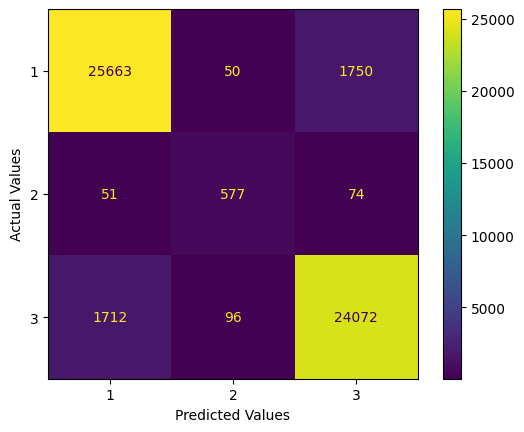

In [13]:
cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

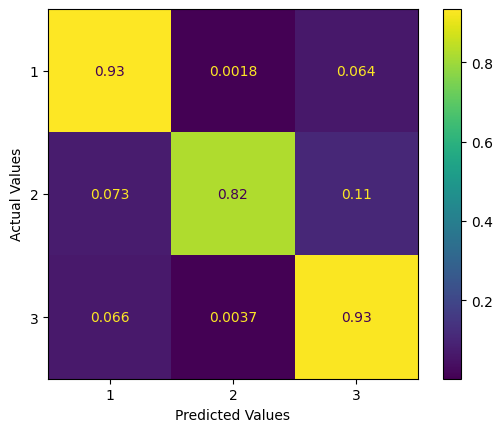

In [14]:
cmd_norm = ConfusionMatrixDisplay(confusion_matrix = cm_norm, display_labels=['1', '2', '3'])
cmd_norm.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [15]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       0.94      0.93      0.94     27463
           2       0.80      0.82      0.81       702
           3       0.93      0.93      0.93     25880

    accuracy                           0.93     54045
   macro avg       0.89      0.90      0.89     54045
weighted avg       0.93      0.93      0.93     54045



Tune the RF model

In [41]:
for m in range(1,51):
    model = RandomForestClassifier(n_estimators=1000, max_depth=m, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy for {m} max_depth is:{accuracy}")

Accuracy for 1 max_depth is:0.6838560458876862
Accuracy for 2 max_depth is:0.6650013877324452
Accuracy for 3 max_depth is:0.6482375797946156
Accuracy for 4 max_depth is:0.63350911277639
Accuracy for 5 max_depth is:0.6547876769358868
Accuracy for 6 max_depth is:0.6719585530576372
Accuracy for 7 max_depth is:0.7016745304838561
Accuracy for 8 max_depth is:0.7243963363863447
Accuracy for 9 max_depth is:0.7551114811730965
Accuracy for 10 max_depth is:0.7836987695438986
Accuracy for 11 max_depth is:0.8137478027569618
Accuracy for 12 max_depth is:0.8407993338884263
Accuracy for 13 max_depth is:0.8682764363030807
Accuracy for 14 max_depth is:0.8940327504857064
Accuracy for 15 max_depth is:0.9143121472846701
Accuracy for 16 max_depth is:0.9296327134795078
Accuracy for 17 max_depth is:0.9393283374965307
Accuracy for 18 max_depth is:0.9427699139605884
Accuracy for 19 max_depth is:0.9429364418540106
Accuracy for 20 max_depth is:0.9416042187066334
Accuracy for 21 max_depth is:0.9385882135257656
Acc

https://github.com/ngoix/scikit-learn/commit/2661da0d3578eda406dcf1867443d9f744165c5f

C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


1 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


2 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


3 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


4 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


5 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


6 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


7 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


8 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


9 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


11 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


13 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


14 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


15 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


16 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


17 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


18 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


19 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


20 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


21 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


22 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


23 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


24 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


25 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


26 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


27 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


28 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


29 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


30 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


31 RandomForestClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


32 RandomForestClassifier (max_features='auto')
33 RandomForestClassifier (max_features='auto')
34 RandomForestClassifier (max_features='auto')
35 RandomForestClassifier (max_features='auto')
36 RandomForestClassifier (max_features='auto')
37 RandomForestClassifier (max_features='auto')
38 RandomForestClassifier (max_features='auto')
39 RandomForestClassifier (max_features='auto')
40 RandomForestClassifier (max_features='auto')
41 RandomForestClassifier (max_features='auto')
42 RandomForestClassifier (max_features='auto')
43 RandomForestClassifier (max_features='auto')
44 RandomForestClassifier (max_features='auto')
45 RandomForestClassifier (max_features='auto')
46 RandomForestClassifier (max_features='auto')
47 RandomForestClassifier (max_features='auto')
48 RandomForestClassifier (max_features='auto')
49 RandomForestClassifier (max_features='auto')
50 RandomForestClassifier (max_features='auto')
51 RandomForestClassifier (max_features='auto')
52 RandomForestClassifier (max_features=

C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


1 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


2 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


3 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


4 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


5 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


6 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


7 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


8 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


9 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


11 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


13 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


14 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


15 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


16 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


17 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


18 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


19 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


20 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


21 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


22 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


23 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


24 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


25 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


26 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


27 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


28 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


29 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


30 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


31 RandomForestClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


32 RandomForestClassifier (max_features=2)
33 RandomForestClassifier (max_features=2)
34 RandomForestClassifier (max_features=2)
35 RandomForestClassifier (max_features=2)
36 RandomForestClassifier (max_features=2)
37 RandomForestClassifier (max_features=2)
38 RandomForestClassifier (max_features=2)
39 RandomForestClassifier (max_features=2)
40 RandomForestClassifier (max_features=2)
41 RandomForestClassifier (max_features=2)
42 RandomForestClassifier (max_features=2)
43 RandomForestClassifier (max_features=2)
44 RandomForestClassifier (max_features=2)
45 RandomForestClassifier (max_features=2)
46 RandomForestClassifier (max_features=2)
47 RandomForestClassifier (max_features=2)
48 RandomForestClassifier (max_features=2)
49 RandomForestClassifier (max_features=2)
50 RandomForestClassifier (max_features=2)
51 RandomForestClassifier (max_features=2)
52 RandomForestClassifier (max_features=2)
53 RandomForestClassifier (max_features=2)
54 RandomForestClassifier (max_features=2)
55 RandomFo

C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


1 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


2 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


3 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


4 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


5 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


6 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


7 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


8 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


9 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


11 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


13 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


14 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


15 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


16 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


17 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


18 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


19 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


20 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


21 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


22 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


23 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


24 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


25 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


26 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


27 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


28 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


29 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


30 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


31 ExtraTreesClassifier (max_features='auto')


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


32 ExtraTreesClassifier (max_features='auto')
33 ExtraTreesClassifier (max_features='auto')
34 ExtraTreesClassifier (max_features='auto')
35 ExtraTreesClassifier (max_features='auto')
36 ExtraTreesClassifier (max_features='auto')
37 ExtraTreesClassifier (max_features='auto')
38 ExtraTreesClassifier (max_features='auto')
39 ExtraTreesClassifier (max_features='auto')
40 ExtraTreesClassifier (max_features='auto')
41 ExtraTreesClassifier (max_features='auto')
42 ExtraTreesClassifier (max_features='auto')
43 ExtraTreesClassifier (max_features='auto')
44 ExtraTreesClassifier (max_features='auto')
45 ExtraTreesClassifier (max_features='auto')
46 ExtraTreesClassifier (max_features='auto')
47 ExtraTreesClassifier (max_features='auto')
48 ExtraTreesClassifier (max_features='auto')
49 ExtraTreesClassifier (max_features='auto')
50 ExtraTreesClassifier (max_features='auto')
51 ExtraTreesClassifier (max_features='auto')
52 ExtraTreesClassifier (max_features='auto')
53 ExtraTreesClassifier (max_featu

C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


1 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


2 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


3 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


4 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


5 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


6 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


7 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


8 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


9 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


11 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


13 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


14 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


15 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


16 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


17 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


18 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


19 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


20 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


21 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


22 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


23 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


24 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


25 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


26 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


27 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


28 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


29 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


30 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


31 ExtraTreesClassifier (max_features=2)


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


32 ExtraTreesClassifier (max_features=2)
33 ExtraTreesClassifier (max_features=2)
34 ExtraTreesClassifier (max_features=2)
35 ExtraTreesClassifier (max_features=2)
36 ExtraTreesClassifier (max_features=2)
37 ExtraTreesClassifier (max_features=2)
38 ExtraTreesClassifier (max_features=2)
39 ExtraTreesClassifier (max_features=2)
40 ExtraTreesClassifier (max_features=2)
41 ExtraTreesClassifier (max_features=2)
42 ExtraTreesClassifier (max_features=2)
43 ExtraTreesClassifier (max_features=2)
44 ExtraTreesClassifier (max_features=2)
45 ExtraTreesClassifier (max_features=2)
46 ExtraTreesClassifier (max_features=2)
47 ExtraTreesClassifier (max_features=2)
48 ExtraTreesClassifier (max_features=2)
49 ExtraTreesClassifier (max_features=2)
50 ExtraTreesClassifier (max_features=2)
51 ExtraTreesClassifier (max_features=2)
52 ExtraTreesClassifier (max_features=2)
53 ExtraTreesClassifier (max_features=2)
54 ExtraTreesClassifier (max_features=2)
55 ExtraTreesClassifier (max_features=2)
56 ExtraTreesCla

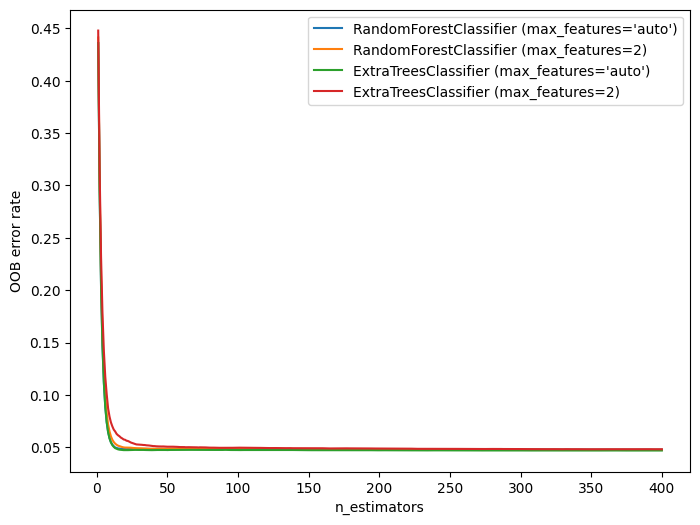

In [51]:

import pylab

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_STATE = 7

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for paralellised ensembles but is necessary for tracking the OOB
# error trajectory during training.
clfs = [
    ("RandomForestClassifier (max_features='auto')",
        RandomForestClassifier(warm_start=True, oob_score=True, max_features=None,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier (max_features='sqrt')",
        RandomForestClassifier(warm_start=True, max_features="sqrt", 
                               oob_score=True, random_state=RANDOM_STATE)),
    ("ExtraTreesClassifier (max_features='auto')",
        ExtraTreesClassifier(warm_start=True, max_features=None,
                             oob_score=True, bootstrap=True,
                             random_state=RANDOM_STATE)),
    ("ExtraTreesClassifier (max_features='sqrt')",
        ExtraTreesClassifier(warm_start=True, max_features="sqrt",
                             oob_score=True, bootstrap=True,
                             random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in clfs)

# Max no. of estimators to use in each ensemble.
n_estimators = 400

for label, clf in clfs:
    for i in range(1, n_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)
        print(i, label)

        # Record the <error rate> for each <n_estimators> setting. 
        error_rate[label].append((i, 1 - clf.oob_score_))

# Generate the "OOB error rate" vs. "no. of estimators" plot
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    pylab.plot(xs, ys, label=label)

pylab.xlabel("n_estimators")
pylab.ylabel("OOB error rate")
pylab.legend(loc="upper right")
pylab.gcf().set_size_inches(8, 6)
pylab.show()

In [70]:
best_accuracy = 0
Depth = []
Acc = []
for m in range(1,51):
    Depth.append(m)

    model = RandomForestClassifier(n_estimators=100, max_depth=m, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    Acc.append(accuracy)

    if accuracy> best_accuracy:
        best_accuracy = accuracy
        best_depth = m
    print(f"Accuracy for {m} max_depth is:{accuracy}")
list_of_tuples = list(zip(Depth, Acc))
df = pd.DataFrame(list_of_tuples, columns=['Depth', 'Accuracy'])

print(f"Best accuracy is: {best_accuracy} and depth is {best_depth}")
    

Accuracy for 1 max_depth is:0.6749560551392358
Accuracy for 2 max_depth is:0.6553797761124989
Accuracy for 3 max_depth is:0.6400592099176612
Accuracy for 4 max_depth is:0.6341567212508095
Accuracy for 5 max_depth is:0.6552872606161532
Accuracy for 6 max_depth is:0.6725876584327874
Accuracy for 7 max_depth is:0.6982884633176057
Accuracy for 8 max_depth is:0.7254695161439542
Accuracy for 9 max_depth is:0.7538902766213341
Accuracy for 10 max_depth is:0.7838652974373207
Accuracy for 11 max_depth is:0.8130076787861967
Accuracy for 12 max_depth is:0.8417985012489592
Accuracy for 13 max_depth is:0.8667776852622814
Accuracy for 14 max_depth is:0.8938107132944768
Accuracy for 15 max_depth is:0.9128133962438708
Accuracy for 16 max_depth is:0.9282264779350541
Accuracy for 17 max_depth is:0.9373485058747341
Accuracy for 18 max_depth is:0.941567212508095
Accuracy for 19 max_depth is:0.9426403922657045
Accuracy for 20 max_depth is:0.9414561939124804
Accuracy for 21 max_depth is:0.9389582755111481
Ac

<Axes: xlabel='Depth'>

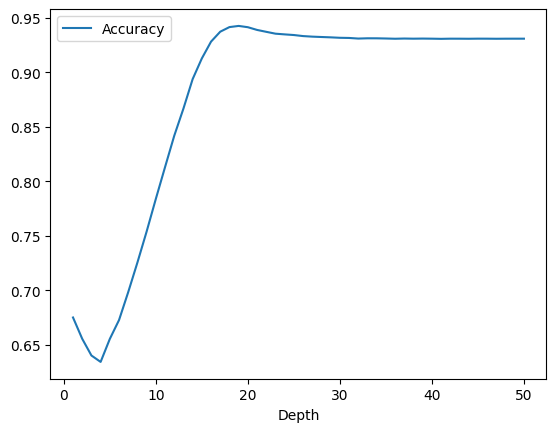

In [69]:
df
df.plot(x='Depth', y='Accuracy', kind="line")

In [80]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, train_test_split

param_dist = {'max_depth': randint(1,20),
              'n_estimators': randint(50,500),
              'max_features': randint(1,8)
              }

# Create a random forest classifier
rf = RandomForestClassifier(random_state=7)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=8, 
                                 cv=5, random_state=7)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'max_features': 4, 'min_samples_leaf': 190, 'min_samples_split': 2, 'n_estimators': 340}


Use the tuned hyperparameters for a new RF

1st - Manually tuned using a validation set

In [71]:
rnd_clf_tweaked_man = RandomForestClassifier(n_estimators=100, max_depth=19, n_jobs=-1, random_state=7)
rnd_clf_tweaked_man.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_jobs=-1, random_state=7)

In [72]:
rnd_clf_tweaked_man_train_score = rnd_clf_tweaked_man.score(X_train, y_train)
rnd_clf_tweaked_man_test_score = rnd_clf_tweaked_man.score(X_test, y_test)
print("Training score:", rnd_clf_tweaked_man_train_score)
print("Testing score:", rnd_clf_tweaked_man_test_score )

Training score: 0.9731298219997649
Testing score: 0.9426403922657045


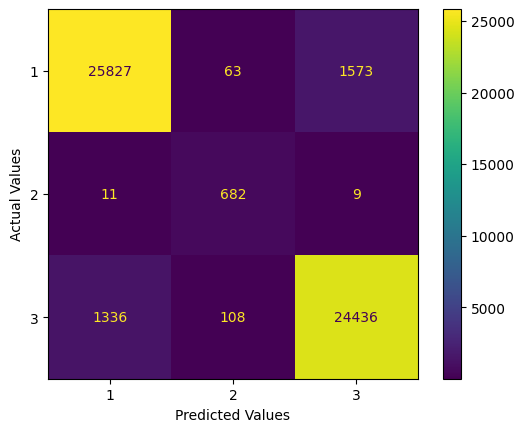

In [73]:
y_tweaked_man_pred_rf = rnd_clf_tweaked_man.predict(X_test)

cm = confusion_matrix(y_test, y_tweaked_man_pred_rf, labels=rnd_clf_tweaked_man.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '2', '3'])
cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

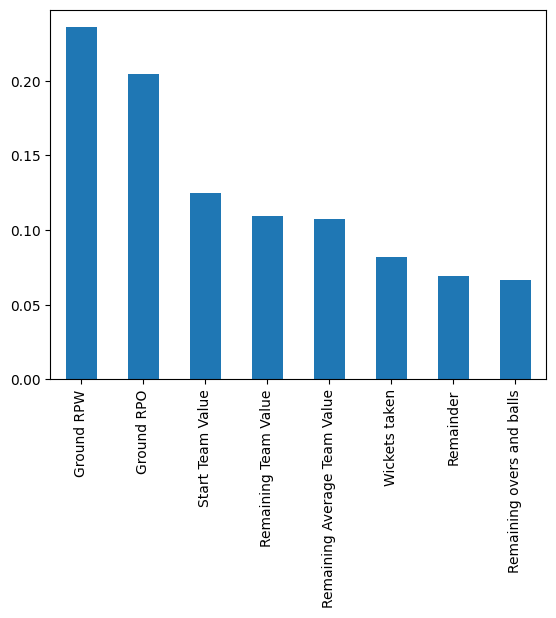

In [76]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rnd_clf_tweaked_man.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

2nd - Tweak with CV version

In [ ]:
rnd_clf_tweaked_CV = RandomForestClassifier(n_estimators=100, max_depth=19, n_jobs=-1, random_state=7)
rnd_clf_tweaked_CV.fit(X_train, y_train)

In [ ]:
rnd_clf_tweaked_CV_train_score = rnd_clf_tweaked_CV.score(X_train, y_train)
rnd_clf_tweaked_CV_test_score = rnd_clf_tweaked_CV.score(X_test, y_test)
print("Training score:", rnd_clf_tweaked_CV_train_score)
print("Testing score:", rnd_clf_tweaked_CV_test_score )

In [ ]:
y_tweaked_CV_pred_rf = rnd_clf_tweaked_CV.predict(X_test)

cm = confusion_matrix(y_test, y_tweaked_CV_pred_rf, labels=rnd_clf_tweaked_CV.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '2', '3'])
cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rnd_clf_tweaked_CV.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

https://www.datacamp.com/tutorial/random-forests-classifier-python